# **EECS598-012: Unsupervised Visual Learning**

Before we start, please put your name and UMID in the following format

: Firstname LASTNAME, #00000000   //   e.g.) Andrew OWENS, #12345678

**Your Answer: Changyuan QIU, #28427971**   


# **PixelCNN**

In this notebook, you'll learn how to train PixelCNN using MNIST dataset. 

The following papers might help you understand the model better. 
- [Van Oord Aaron et al. Pixel Recurrent Neural Networks](https://arxiv.org/pdf/1601.06759.pdf)

The problem set is **due** on **Apr. 21**.

**Acknowledgement:** This notebook is based on the assignment of EECS 498-007 / 598-005 given by Justin Johnson and CS294-158-SP20 given by Pieter Abbeel, Peter Chen, Jonathan Ho and Aravind Srinivas.


We'll use Google Colab to do the homework. You'll write the code in the *.py files, and run the model in this notebook. Colab provides GPU resources, and it's also fine to use your local machine. 

You'll be required to upload your notebook code and *.py code to Gradescope as a *.zip file. 

## Setup Code

Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

- Check whether you have access to **GPU** resources on Colab. Go to **Runtime -> Change runtime type** and make sure you have selected **GPU** as the hardware accelerator. 
- Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the following cell should print the filenames from the assignment:

```
['.ipynb_checkpoints', 'utils', 'models', 'imgs', 'data', 'bigan.ipynb', 'vae.ipynb', 'av_loc.ipynb', 'pixel_cnn.ipynb']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2021WIN folder and put all the files under EECS598-012-ProblemSets folder, then '2021WIN/EECS598-012-ProblemSets'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2021-Winter/EECS598-012-Unsupervised-CV/EECS598-012-ProblemSets' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['vae.ipynb', 'bigan.ipynb', 'av_loc.ipynb', '.DS_Store', 'models', 'utils', 'dataset', 'pixel_cnn.ipynb']


In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

In [5]:
import torch

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import utils

We will work with the MNIST dataset. Run the cell below to visualize the dataset. Note that the image can be viewed as a flattened *binary* vector $x \in \{0, 1\}^{HW}$, where $H$ and $W$ are the height and width of the image. 

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


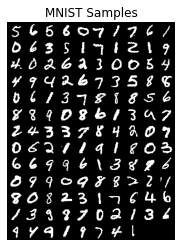

In [6]:
data_dict = utils.preprocess_mnist(show_examples=True, binary_input=True)
train_data = np.expand_dims(data_dict['X_train'], 1)
test_data = np.expand_dims(data_dict['X_test'], 1)
train_labels = data_dict['Y_train']
test_labels = data_dict['Y_test']

In [73]:
print(train_data.shape, train_data.min(), train_data.max())
print(test_data.shape, test_data.min(), test_data.max())

(60000, 1, 28, 28) 0.0 1.0
(10000, 1, 28, 28) 0.0 1.0


In this part, you'll implement a simple PixelCNN model, and use the MNIST dataset to train the model. 

We provide a training code in **models/pixel_cnn_solver.py** and a model template in **models/pixel_cnn_model.py**. You'll fill in the code marked by **TODO** in the file **models/pixel_cnn_model.py**. Please follow the instructions and fill in the functions in these two files. 

We provide the functions for plotting and visualizing images. **You'll provide the following results.**
- Record the average negative log-likelihood (per mini-batch) during training for training data, and log-likelihood (per epoch) for testing data. 
- Sample 100 images using the trained model. 

The training on the MNIST dataset takes around 10 minutes for 10 epochs. 


Epoch 0 loss: 0.7023:   0%|          | 256/60000 [00:00<00:27, 2177.91it/s]

0.7659


Epoch 1 loss: 0.0866:   0%|          | 256/60000 [00:00<00:27, 2158.93it/s]

0.0863
Epoch 0, Test loss 0.0863


Epoch 2 loss: 0.0877:   0%|          | 256/60000 [00:00<00:27, 2163.18it/s]

0.0832
Epoch 1, Test loss 0.0832


Epoch 3 loss: 0.0853:   0%|          | 256/60000 [00:00<00:27, 2172.17it/s]

0.0848
Epoch 2, Test loss 0.0848


Epoch 4 loss: 0.0820:   0%|          | 256/60000 [00:00<00:27, 2175.05it/s]

0.0800
Epoch 3, Test loss 0.0800


Epoch 5 loss: 0.0794:   0%|          | 256/60000 [00:00<00:27, 2174.61it/s]

0.0800
Epoch 4, Test loss 0.0800


Epoch 6 loss: 0.0779:   0%|          | 256/60000 [00:00<00:27, 2149.61it/s]

0.0789
Epoch 5, Test loss 0.0789


Epoch 7 loss: 0.0775:   0%|          | 256/60000 [00:00<00:27, 2143.06it/s]

0.0783
Epoch 6, Test loss 0.0783


Epoch 8 loss: 0.0754:   0%|          | 256/60000 [00:00<00:27, 2174.47it/s]

0.0793
Epoch 7, Test loss 0.0793


Epoch 9 loss: 0.0786:   0%|          | 256/60000 [00:00<00:27, 2170.72it/s]

0.0795
Epoch 8, Test loss 0.0795


Epoch 9 loss: 0.0737: 100%|██████████| 60000/60000 [00:27<00:00, 2190.20it/s]


0.0774
Epoch 9, Test loss 0.0774
Final Test Loss: 0.0774


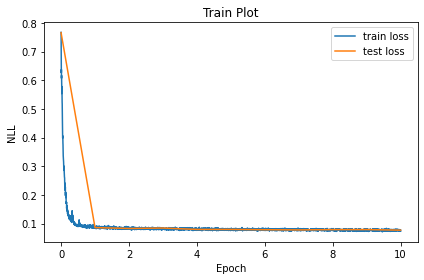

Epoch 1 loss: 0.0000:  19%|█▉        | 11392/60000 [09:04<38:43, 20.92it/s]  


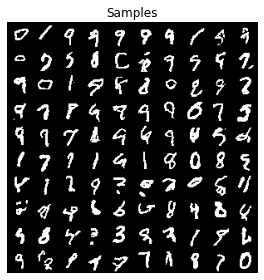

In [106]:
from models.pixel_cnn_solver import train_pixel_cnn
from utils.vis import show_samples, save_training_plot

nll_train, nll_test, samples = train_pixel_cnn(train_data, test_data, quiet=False)

samples = samples.cpu().numpy().astype('float32') * 255
print(f'Final Test Loss: {nll_test[-1]:.4f}')
save_training_plot(nll_train, nll_test, 'Train Plot', 'results/pixelcnn_q1_train_plot.png')
show_samples(samples.squeeze(), 'results/pixelcnn_q1_samples.png', gray=True)


In [105]:
tqdm._instances.clear()